# Exporting Data to Pardiso and Calculating Band Structure

This tutorial demonstrates how to use the `to_pardiso` method of the `TBSystem` class in DeePTB to export Hamiltonian and overlap matrices, along with structural information, into a format suitable for the Pardiso solver (via a Julia script).

## Objectives
1. Initialize a `TBSystem` with a structure and a trained model.
2. Export the system data using `to_pardiso`.
3. Setup the Julia environment and install necessary packages.
4. Run the external Julia script to calculate the band structure using the exported data.


## 1. Setup Paths

We need to define the paths to our model checkpoint (`.pth`) and the atomic structure file (`.vasp`)., and the Julia script.

In [ ]:
import os
import shutil
import torch
import numpy as np
import subprocess
from pathlib import Path
from dptb.postprocess.unified.system import TBSystem

root_dir = os.path.abspath("../Pardiso_teach") 
model_path = os.path.join(root_dir,  "nnsk.iter_ovp0.000.pth")
struct_path = os.path.join(root_dir, "min.vasp")
output_dir = os.path.join(root_dir, "output")



TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
Pybinding is not installed. Please install it via `pip install pybinding`


## 2. Initialize TBSystem

We create an instance of `TBSystem`, which loads the atomic structure and the Hamiltonian calculator.

In [2]:
# Initialize the TBSystem
tbsys = TBSystem(data=struct_path, calculator=model_path)
print("TBSystem initialized successfully.")
print(f"System Info: {tbsys.atoms}")

TBSystem initialized successfully.
System Info: Atoms(symbols='C84', pbc=True, cell=[93.478815071, 28.220313831, 4.26])


## 3. Export Data to Pardiso Format

The `tbsys.to_pardiso` method generates several files required by the Julia script:
- `atomic_numbers.dat`: Atomic numbers of the system.
- `positions.dat`: Atomic positions.
- `cell.dat`: Lattice vectors.
- `basis.dat`: Basis set information.
- `predicted_hamiltonians.h5`: The Hamiltonian matrices.
- `predicted_overlaps.h5`: The overlap matrices (if applicable).

In [3]:
# Clean up previous output if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

tbsys.to_pardiso(output_dir=output_dir)

print(f"Data exported to {output_dir}")
print("Generated files:")
for f in sorted(os.listdir(output_dir)):
    print(f" - {f}")

Data exported to /home/vasp/deeptb_fork/DeePTB/examples/Get_hr/Pardiso_teach/output
Generated files:
 - atomic_numbers.dat
 - basis.dat
 - cell.dat
 - positions.dat
 - predicted_hamiltonians.h5
 - predicted_overlaps.h5


## 4. Setup Julia Environment

Before running the script, we need to ensure that Julia is installed and the required packages are available.

### 4.1 Install Julia
If you haven't installed Julia yet, please download it from the official website: [https://julialang.org/downloads/](https://julialang.org/downloads/).
After installation, make sure the `julia` executable is in your system's `PATH`. You can verify this by running the following cell.

In [4]:
import subprocess

try:
    # Check Julia version
    result = subprocess.run(["julia", "--version"], capture_output=True, text=True, check=True)
    print(f"Julia is installed: {result.stdout.strip()}")
except (FileNotFoundError, subprocess.CalledProcessError):
    print("Error: 'julia' executable not found. Please install Julia and add it to your PATH.")
    raise RuntimeError("Julia is required for the next steps.")

Julia is installed: julia version 1.6.6


### 4.2 Install Required Packages

The `sparse_calc_npy_print.jl` script depends on several Julia packages:
- `DelimitedFiles`
- `LinearAlgebra`
- `JSON`
- `HDF5`
- `ArgParse`
- `SparseArrays`
- `Pardiso`
- `Arpack`
- `LinearMaps`
- `JLD`
- `FileIO`
- `Dates`
- `Printf`

We can install these packages directly using Julia's package manager (`Pkg`). 

## 5. Run Julia Script

Now that the environment is set up, we use the exported data to calculate the band structure. We need a configuration file (`band.json`) which defines the calculation parameters (e.g., K-path).

In [16]:
# Path to the configuration file
config_path = os.path.join(root_dir, "band.json")

# Define where Julia should save the results
julia_out_dir = os.path.join(output_dir, "julia_results")
if not os.path.exists(julia_out_dir):
    os.makedirs(julia_out_dir)

julia_script = os.path.join("../../..", "dptb/postprocess/julia/sparse_calc_npy_print.jl")

# Construct the command
cmd = [
    "julia",
    julia_script,
    "--input_dir", output_dir,
    "--output_dir", julia_out_dir,
    "--config", config_path
]

print(f"Running Julia command: {' '.join(cmd)}")
print("This may take a moment...")

try:
    # Run the script
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    print("Julia Execution Successful!")
except subprocess.CalledProcessError as e:
    print("Julia script failed with error:")
    print(e.stdout)
    print(e.stderr)

Running Julia command: julia ../../../dptb/postprocess/julia/sparse_calc_npy_print.jl --input_dir /home/vasp/deeptb_fork/DeePTB/examples/Get_hr/Pardiso_teach/output --output_dir /home/vasp/deeptb_fork/DeePTB/examples/Get_hr/Pardiso_teach/output/julia_results --config /home/vasp/deeptb_fork/DeePTB/examples/Get_hr/Pardiso_teach/band.json
This may take a moment...
Julia Execution Successful!


## 6. View Results

The Julia script produces a `bandstructure.npy` file. We can load this file to verify the output.

In [17]:
expected_npy = os.path.join(julia_out_dir, "bandstructure.npy")
data = np.load(expected_npy, allow_pickle=True).item()
print("Successfully loaded bandstructure.npy")
print(f"Data keys: {list(data.keys())}")
if 'eigenvalues' in data:
    evals = data['eigenvalues']
    print(f"Eigenvalues shape: {evals.shape}")


Successfully loaded bandstructure.npy
Data keys: ['eigenvalues', 'xlist', 'labels', 'E_fermi', 'output_path', 'high_sym_kpoints', 'klist']
Eigenvalues shape: (101, 15)


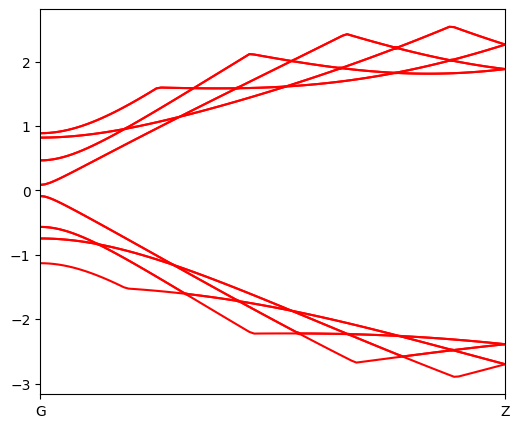

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.plot(data["xlist"],data["eigenvalues"]-data["E_fermi"],'r-')
plt.xticks(data["high_sym_kpoints"], data["labels"])
plt.xlim(0,data["xlist"][-1])
plt.xlabel
plt.show()